# **PHYS 449: Final Project Notebook**
#### Reproducing results from "Morphological classification of galaxies with deep learning: comparing 3-way and 4-way CNNs" by Mitchell K. Cavanagh, Kenji Bekki and Brent A. Groves

Using galax10 dataset, specifically the g-band filter and keras

# **Settings for Run**


In [11]:
# can set both to true
run_C1 = True 
run_C2 = True

# can only be 3 or 4
num_class = 3

In [12]:
# train, test, validation splits
train_split = 0.85
valid_split = 0.15
test_split = 0.15 # do shuffle to get this

In [13]:
input_shape = (69,69,1) # images of 69x69

# **Imports**

In [14]:
!pip install astroNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 37.0 MB/s 
     |████████████████████████████████| 4.5 MB 61.3 MB/s 
     |████████████████████████████████| 885 kB 85.5 MB/s 
     |████████████████████████████████| 48 kB 6.3 MB/s 
     |████████████████████████████████| 4.0 MB 74.7 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284593 sha256=907d70a22a2bf9091e7b6e8c79eae51855711d64f20130ea4ab86a38dc773ec7
  Stored in directory: /root/.cache/pip/wheels/f2/b6/1f/222aea123a5de8a34c3dd95bb73dca35e342ef3901328e9db0
Successfully built astroNN


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers.core import Dropout
import os
from sklearn.metrics import confusion_matrix

In [16]:
#from astroNN.datasets import galaxy10
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [17]:
# use this if you get SSL error on data download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# **Setup Galaxy10**

Code and dataset from https://astronn.readthedocs.io/en/latest/galaxy10.html

In [18]:
# ---------------------------------------------------------#
#   astroNN.datasets.galaxy10: galaxy10
# ---------------------------------------------------------#

import os
import urllib.request

import h5py
import numpy as np

from astroNN.config import astroNN_CACHE_DIR
from astroNN.shared.downloader_tools import TqdmUpTo
from astroNN.shared.downloader_tools import sha256_checksum

Galaxy10Class = {0: "Disk, Face-on, No Spiral",
                 1: "Smooth, Completely round",
                 2: "Smooth, in-between round",
                 3: "Smooth, Cigar shaped",
                 4: "Disk, Edge-on, Rounded Bulge",
                 5: "Disk, Edge-on, Boxy Bulge",
                 6: "Disk, Edge-on, No Bulge",
                 7: "Disk, Face-on, Tight Spiral",
                 8: "Disk, Face-on, Medium Spiral",
                 9: "Disk, Face-on, Loose Spiral"}

_G10_ORIGIN = 'http://astro.utoronto.ca/~bovy/Galaxy10/'


def load_data(flag=None):
    """
    NAME:
        load_data
    PURPOSE:
        load_data galaxy10 data
    INPUT:
        None
    OUTPUT:
        x (ndarray): An array of images
        y (ndarray): An array of answer
    HISTORY:
        2018-Jan-22 - Written - Henry Leung (University of Toronto)
    """

    filename = 'Galaxy10.h5'

    complete_url = _G10_ORIGIN + filename

    datadir = os.path.join(astroNN_CACHE_DIR, 'datasets')
    file_hash = '969A6B1CEFCC36E09FFFA86FEBD2F699A4AA19B837BA0427F01B0BC6DED458AF'  # SHA256

    # Notice python expect sha256 in lowercase

    if not os.path.exists(datadir):
        os.makedirs(datadir)
    fullfilename = os.path.join(datadir, filename)

    # Check if files exists
    if os.path.isfile(fullfilename) and flag is None:
        checksum = sha256_checksum(fullfilename)
        if checksum != file_hash.lower():
            print('File corruption detected, astroNN attempting to download again')
            load_data(flag=1)
        else:
            print(fullfilename + ' was found!')
    elif not os.path.isfile(fullfilename) or flag == 1:
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=complete_url.split('/')[-1]) as t:
            urllib.request.urlretrieve(complete_url, fullfilename, reporthook=t.update_to)
            print(f'Downloaded Galaxy10 successfully to {fullfilename}')
            checksum = sha256_checksum(fullfilename)
            if checksum != file_hash.lower():
                load_data(flag=1)

    with h5py.File(fullfilename, 'r') as F:
        x = np.array(F['images'])
        y = np.array(F['ans'])

    return x, y


def galaxy10cls_lookup(class_num):
    """
    NAME:
        galaxy10cls_lookup
    PURPOSE:
        look up class name for Galaxy10
    INPUT:
        class_num (int): An integer 0-9
    OUTPUT:
        (string): Name of the class
    HISTORY:
        2018-Feb-07 - Written - Henry Leung (University of Toronto)
    """
    if isinstance(class_num, list) or isinstance(class_num, np.ndarray):
        class_num = np.argmax(class_num)
    if 0 > class_num or 9 < class_num:
        raise ValueError(f'Galaxy10 only has 10 classes, you entered {class_num}')
    return Galaxy10Class[class_num]


def galaxy10_confusion(confusion_mat):
    """
    NAME:
        galaxy10_confusion
    PURPOSE:
        to plot confusion matrix
    INPUT:
        confusion_mat (ndarray): An integer 0-9
    OUTPUT:
        (string): Name of the class
    HISTORY:
        2018-Feb-11 - Written - Henry Leung (University of Toronto)
    """
    import pylab as plt

    conf_arr = confusion_mat.astype(int)

    norm_conf = []
    a = np.max(conf_arr)
    for i in conf_arr:
        tmp_arr = []
        for j in i:
            tmp_arr.append(float(j) / float(a))
        norm_conf.append(tmp_arr)

    fig, ax = plt.subplots(1, figsize=(10, 10.5), dpi=100)
    fig.suptitle("Confusion Matrix for Galaxy10 trained by astroNN", fontsize=18)
    ax.set_aspect(1)
    ax.imshow(np.array(norm_conf), cmap=plt.get_cmap('Blues'), interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')

    alphabet = '0123456789'
    plt.xticks(range(width), alphabet[:width], fontsize=20)
    plt.yticks(range(height), alphabet[:height], fontsize=20)
    ax.set_ylabel('Prediction class by astroNN', fontsize=18)
    ax.set_xlabel('True class', fontsize=18)
    fig.tight_layout(rect=[0, 0.00, 0.8, 0.96])
    fig.show()

    return None


#----------------------------------------#
#----------------------------------------#
#----------------------------------------#

# **Load images, labels**

In [19]:
images, labels = load_data()
print('l shape before =', labels.shape)
print(labels)

Galaxy10.h5:  99%|█████████▉| 208M/210M [00:19<00:00, 13.6MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:19, 10.6MB/s]                           


l shape before = (21785,)
[2 2 4 ... 2 9 2]


In [20]:
labels = labels.astype(np.float32)
print('label shape before =', labels.shape)
labels = tf.keras.utils.to_categorical(labels)
print('l shape after =', labels.shape)
images = images.astype(np.float32)
print('i shape before =', images.shape)
images = images/255
print('i shape after =', images.shape)

label shape before = (21785,)
l shape after = (21785, 10)
i shape before = (21785, 69, 69, 3)
i shape after = (21785, 69, 69, 3)


# **Condense Classes**
The galaxy10 playlist natively has 10 classes but we can condense this into 3 or 4

In [21]:
if num_class == 4:
  #This takes the old labels with 10 classes and turns it into 4
  elliptical = [1,2,3]
  lenticular = [4,5,6]
  spiral = [7,8,9]
  irregular = [0]
  name = [0,1,2,3]

  def change_class4(lable):
      label_num_pos = int(np.where(lable==1)[0])
      if label_num_pos in elliptical:
          new_name = np.array([1.,0.,0.,0.])
      if label_num_pos in lenticular:
          new_name = np.array([0.,1.,0.,0.])
      if label_num_pos in spiral:
          new_name = np.array([0.,0.,1.,0.])
      if label_num_pos in irregular:
          new_name = np.array([0.,0.,0.,1.])
      return new_name
  new_labels = np.array([change_class4(labels[i]) for i in range(len(labels))])

elif num_class == 3:
  #This takes the old labels with 10 classes and turns it into 3
  elliptical = [1,2,3]
  lenticular = [4,5,6]
  spiral = [7,8,9,0]
  name = [0,1,2]

  def change_class3(lable):
      label_num_pos = int(np.where(lable==1)[0])
      if label_num_pos in elliptical:
          new_name = np.array([1.,0.,0.])
      if label_num_pos in lenticular:
          new_name = np.array([0.,1.,0.])
      if label_num_pos in spiral:
          new_name = np.array([0.,0.,1.])
      return new_name

  new_labels = np.array([change_class3(labels[i]) for i in range(len(labels))])

print(new_labels[:10])
print(labels.shape, new_labels.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
(21785, 10) (21785, 3)


In [22]:
# only take one layer (we can think which one is best, i can just run all 3), first one is g band i think
# only select one filter
images = images[:,:,:,0]
print(images.shape)


(21785, 69, 69)


# **Number of images in each label**

In [23]:
#This shows the amount in each label
label_categor_nums = [int(np.where(new_labels[i]==1)[0]) for i in range(len(new_labels))]
#print(label_categor_nums[:15])

name_occur = [label_categor_nums.count(name[i]) for i in range(len(name))]
print(name_occur)

[13638, 2140, 6007]


# **Data split: train, test**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(images, new_labels, test_size = test_split)
print(X_train.shape)
print(y_train.shape)

(18517, 69, 69)
(18517, 3)


# **CNN Models**

In [25]:
def C1(input_shape, unique_labels=num_class, dropout_rate=0.5):
    '''
    Defines the 2D Convolutional Neural Network (CNN) called C1
    Parameters:    
    
        input_shape (arr): input shape for network
        unique_labels (int): number unique labels 
        dropout_rate (float): dropout rate as fraction

    Returns:
        
        model (keras model class): CNN to train
    '''

    model = Sequential()

    model.add(Conv2D(filters=32, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(Conv2D(filters=64, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(unique_labels, activation='softmax')) 

    return model

In [26]:
def C2(input_shape, unique_labels=num_class, dropout_rate=0.5):
    '''
    Defines the 2D Convolutional Neural Network (CNN) called C2
    Parameters:    
    
        input_shape (arr): input shape for network
        unique_labels (int): number unique labels 
        dropout_rate (float): dropout rate as fraction

    Returns:
        
        model (keras model class): CNN to train
    '''
    
    model = Sequential()

    model.add(Conv2D(filters=32, input_shape=input_shape, activation='relu', kernel_size=(7,7)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(Conv2D(filters=64, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, input_shape=input_shape, activation='relu', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(unique_labels, activation='softmax')) 

    return model

# **Begin Training**

In [42]:
# define hyperparameters of training
if run_C1:
  n_epochs = 13
  # can't find learning rate mentioned so I'm leaving it as default for now
  
  ###opt = keras.optimizers.Adadelta()
  ### using adam stuff temporarily
  lr = 2*pow(10,-4)
  opt = keras.optimizers.Adam(learning_rate=lr) # try just using this learning rate
  
  c1_model = C1(input_shape)

  # show model architecture
  c1_model.summary()

  c1_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  c1_classifier = c1_model.fit(X_train, y_train, epochs=n_epochs, validation_split=valid_split)  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 65, 65, 32)        832       
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dropout_2 (Dropout)         (None, 57600)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               14745856  
                                                      

c1 still not learning well, need to look into it

In [28]:
if run_C2:
  n_epochs = 20
  lr = 2*pow(10,-4)
  opt = keras.optimizers.Adam(learning_rate=lr)
  c2_model = C2(input_shape)
  # show model architecture
  c2_model.summary()

  c2_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  c2_classifier = c2_model.fit(X_train, y_train, epochs=n_epochs, validation_split=valid_split)  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 63, 63, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 64)        51264     
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 64)      

In [29]:
#^ make above a function to be able to run in loop for 3/4 way too (a run all vs just one mode)

# **Save the model (optional)**

In [30]:
# import pandas
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# import pickle
# # save the model to disk
# keras_c2_galaxy10_4cl = 'keras_c2_galaxy10_4cl.sav'
# pickle.dump(model, open(keras_c2_galaxy10_4cl, 'wb'))

# **Plot Training & Validation Loss, Accuracy**
Trying to get a plot that looks like yours

Text(0, 0.5, 'Loss')

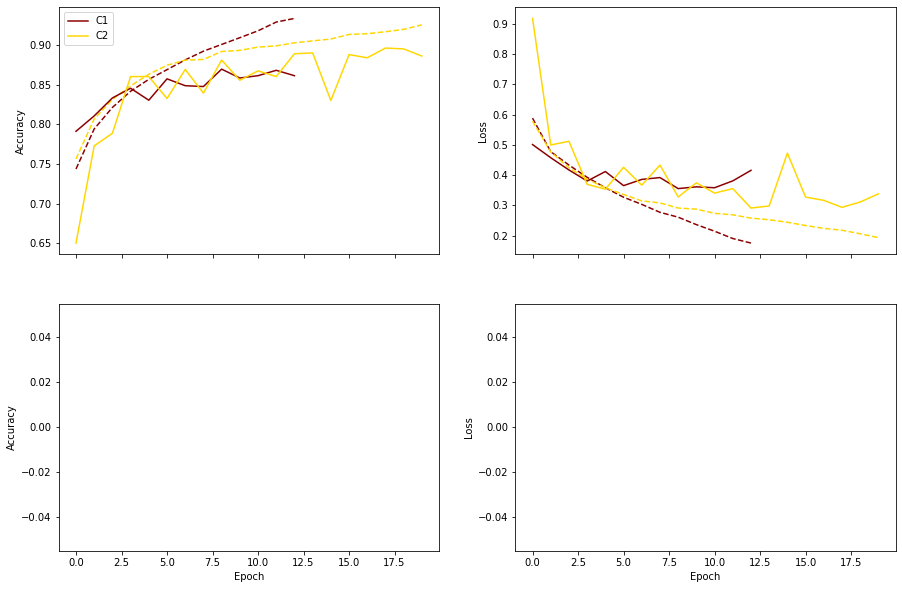

In [43]:
# plot accuracy/loss versus epoch
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15, 10))
axs[0, 0].plot(c1_classifier.history['accuracy'], '--', color='darkred')
axs[0, 0].plot(c2_classifier.history['accuracy'], '--', color='gold')
axs[0, 0].plot(c1_classifier.history['val_accuracy'], label='C1', color='darkred')
axs[0, 0].plot(c2_classifier.history['val_accuracy'], label='C2', color='gold')
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 1].plot(c1_classifier.history['loss'], '--', color='darkred')
axs[0, 1].plot(c2_classifier.history['loss'], '--', color='gold')
axs[0, 1].plot(c1_classifier.history['val_loss'], label='C1', color='darkred')
axs[0, 1].plot(c2_classifier.history['val_loss'], label='C2', color='gold')
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 1].set_ylabel('Loss')
axs[1, 0].plot()
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 1].plot()
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')

ik this colour is ugly but I'm just trying to make it resemble what they have

In [ ]:
plt.plot(model.history.history['loss'],color='b',
label='Training Loss')
plt.plot(model.history.history['val_loss'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',
label='Validation Accuracy')
plt.legend()
plt.show()

# **Confusion Matrix**

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10


predictions = model.predict(X_test)
predictions = (predictions > 0.5) 
labels = ["elliptical", "lenticular", "spiral", "irregular"]

cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()